In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from scipy import signal
import glob
from astropy.table import Table
import os
homedir = os.path.expanduser('~')
from Starfish.spectrum import Spectrum
from Starfish.models import SpectrumModel
import emcee
import scipy.stats as st
import arviz as az
import corner

In [2]:
filelist = sorted(glob.glob(f'{homedir}/uoedrive/data/IGRINS/SDCK*_1f.spec.fits'))
fluxes = []
wls = []

for filename in filelist:
    wlname = filename.split('_1f')[0]+'.wave.fits'

    flux = fits.getdata(filename)
    wl = fits.getdata(wlname)
    hdr = fits.getheader(filename)
    # trim first and last 100 columns
    flux = flux[:, 100:1948]
    wl = wl[:, 100:1948]
    
    fluxes.append(flux)
    wls.append(wl)
dims = np.array(fluxes).shape
fluxes = np.array(fluxes)
wls = np.array(wls)

obs0 = np.median(fluxes[:, 1:, :], axis=0)*dims[0]  # make mean spectrum
eobs0 = np.median(fluxes[:, 1:, :], axis=0)*np.sqrt(dims[0])  # make mean noise spectrum (assuming just photon noise)
fobs0 = np.vstack([signal.medfilt(obs0[jj], 3) for jj in range(dims[1]-1)])  # smooth spectrum
# fix wavelength array to have same shape
wls = wls[:, 1:24, :] 

In [3]:
obs=22
order=5
wl_order = wls[obs, order, :] *10000
flux_order = fobs0[order]
data = Spectrum(wl_order, flux_order, sigmas=None, masks=None, name="Spectrum")
#fitted params:
# chisq = 346
# vsini = 30.45525347753552
# rv = 0.8606
# lld = 8.589e-05
# wcoef = [ 0.00024143 -0.00397479  0.03418952], [ 0.00024143 -0.00397479  0.03418952], [ 0.0002946  -0.00408566  0.03425189], [ 0.0002946  -0.00408566  0.03425189]
# ccoef = [2.45280359 0.2117408 ], [2.45280359 0.2117408 ]

### Setting up the model
Some of these parameters are based on guesses or pre-existing knowledge. In particular, if you want to fit `log_scale`, you should spend some time tuning it by eye, first. We also want our `global_cov:log_amp` to be reasonable, so pay attention to the $\sigma$-contours in the residuals plots, too.

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: None

Parameters
  vsini: 25
  vz: 105
  global_cov:
    log_amp: 0
    log_ls: 1
  cheb: [0, 0]
  T: 1500
  logg: 5.0
  log_scale: 3.934758912387137 (fit)

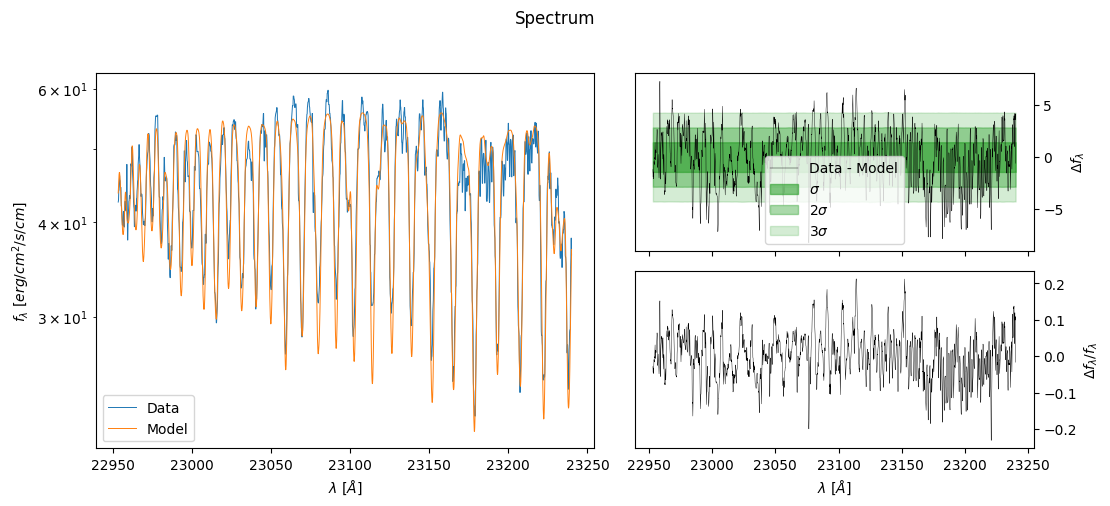

In [27]:
model = SpectrumModel(
    emulator="BTSettl_K_emu.hdf5",
    data=data,
    grid_params=[1500, 5.0],
    vsini=25,
    vz=105,
    cheb=[0, 0],
    global_cov=dict(log_amp=0, log_ls=1),
)
model.plot()
model

#### MCMC Sampling

Here we specify some priors using `scipy.stats` classes. If you have a custom distribution you want to use, create a class and make sure it has a `logpdf` member function.

In [28]:
priors = {
    "T": st.uniform(500,2500),
    "vsini": st.uniform(0, 500),
    "vz": st.uniform(10, 100),
    "cheb:1": st.uniform(-3, 6),
    "cheb:2": st.uniform(-3, 6),
    "global_cov:log_amp": st.norm(0, 5),
    "global_cov:log_ls": st.uniform(0, 10),
}
model.log_likelihood(priors)

-1920.8354958407283

In [29]:
#model.load("example_MAP_1.toml")
model.freeze("logg")
model.labels  # These are the fittable parameters

('vsini',
 'vz',
 'global_cov:log_amp',
 'global_cov:log_ls',
 'cheb:1',
 'cheb:2',
 'T')

Numerical Optimization

In [30]:
%time model.train(priors, options={"maxiter": 1000})

/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py:324: RuntimeWarning: invalid value encountered in log
  self._log_scale = np.log(scale)


CPU times: user 2h 2min 32s, sys: 6h 23min 3s, total: 8h 25min 36s
Wall time: 8min 59s


 final_simplex: (array([[ 2.74429007e+01,  1.04532175e+02,  1.67786285e+00,
         8.08095271e-01, -1.06393762e+00,  1.80802102e-01,
         1.25134544e+03],
       [ 2.74195303e+01,  1.04461701e+02,  1.66691665e+00,
         8.10703993e-01, -1.04677544e+00,  1.71825804e-01,
         1.24570578e+03],
       [ 2.73926412e+01,  1.04534501e+02,  1.67985600e+00,
         8.15625499e-01, -1.04009312e+00,  1.61841583e-01,
         1.24636052e+03],
       [ 2.72557647e+01,  1.04550507e+02,  1.66681456e+00,
         8.08221638e-01, -1.04101388e+00,  1.67536132e-01,
         1.26254375e+03],
       [ 2.74420825e+01,  1.04484289e+02,  1.66487467e+00,
         8.02299192e-01, -1.05591403e+00,  1.79595592e-01,
         1.25961161e+03],
       [ 2.73007613e+01,  1.04444878e+02,  1.66289211e+00,
         8.02989019e-01, -1.04082859e+00,  1.68876757e-01,
         1.25332957e+03],
       [ 2.74582213e+01,  1.04550396e+02,  1.67596604e+00,
         8.09395599e-01, -1.02949996e+00,  1.55223951e-01,
 

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -1389.1828036246

Parameters
  vsini: 27.487836554478946
  vz: 104.5624946193285
  cheb: [-1.0847554286583092, 0.19327510656988545]
  T: 1247.2188672240418
  log_scale: 6.098372504983905 (fit)

Frozen Parameters
  logg: 5.0
  global_cov:log_amp: 1.6868733647391352
  global_cov:log_ls: 0.809105069513274

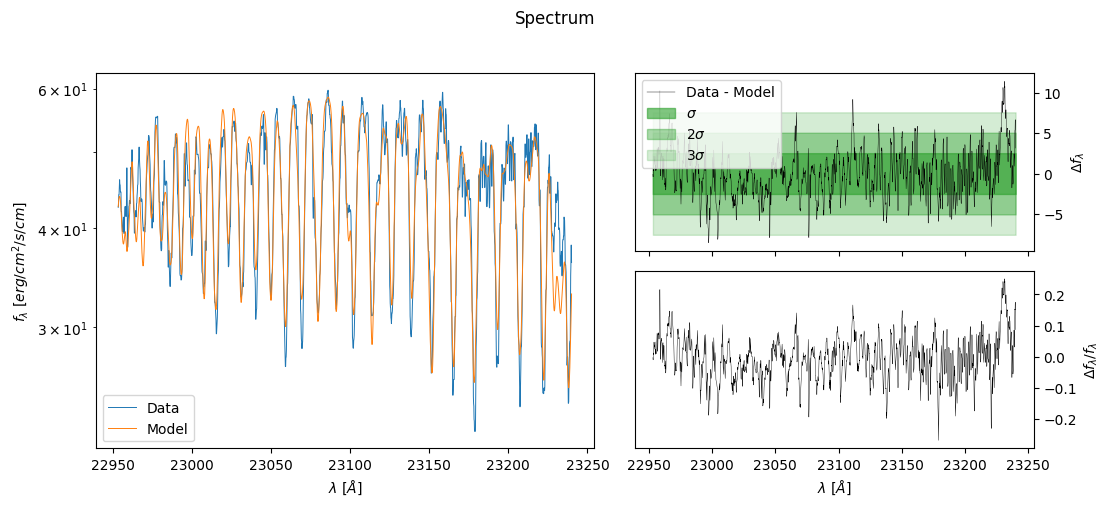

In [31]:
model.plot()
model.freeze("global_cov")
model

In [32]:
# Set our walkers and dimensionality
nwalkers = 10
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1, "cheb:1": 1, "cheb:2":1}

ball = np.random.randn(nwalkers, ndim)

for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

# our objective to maximize
def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(priors,), backend=backend
)

here we start our sampler, check every 10 steps for convergence, with a max burn-in of 1000 samples.

<div class="alert alert-warning">

**Warning:** This process *can* take a long time to finish. In cases with high resolution spectra or fully evaluating each nuisance covariance parameter, we recommend running on a remote machine. A setup I recommend is a remote jupyter server, so you don't have to create any scripts and can keeping working in notebooks.

</div>

In [33]:
max_n = 500

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(ball, iterations=max_n, progress=True):
    # Only check convergence every 10 steps
    if sampler.iteration % 10:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1
    # skip math if it's just going to yell at us
    if np.isnan(tau).any() or (tau == 0).any():
        continue
    # Check convergence
    converged = np.all(tau * 10 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.02)
    if converged:
        print(f"Converged at sample {sampler.iteration}")
        break
    old_tau = tau

/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py:324: RuntimeWarning: invalid value encountered in log
  self._log_scale = np.log(scale)
 40%|████      | 201/500 [10:48<15:37,  3.14s/it]Traceback (most recent call last):
  File "/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3675669/329833568.py", line 17, in log_prob
    return model.log_likelihood(priors)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 306, in __call__
    weights, weights_cov = self.emulator(self.grid_params)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/emulator/emulator.py", line 378, in __call__
    raise ValueError("Querying emulator outside of original paramet

emcee: Exception while calling your likelihood function:
  params: [ 2.74995035e+01  1.05769461e+02 -1.15792755e+00  2.94572509e-01
  1.19512258e+03]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dc750d130>, 'vsini': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dcaa8e640>, 'vz': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dcaf95040>, 'cheb:1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dc742ad90>, 'cheb:2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dcb2d2b50>, 'global_cov:log_amp': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dcafac2b0>, 'global_cov:log_ls': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f5dc79210d0>},)
  kwargs: {}
  exception:


ValueError: Querying emulator outside of original parameter range.

Parallelized version

In [86]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

nwalkers = 100
ndim = len(model.labels)

# Initialize gaussian ball for starting point of walkers
scales = {"T": 1, "vsini": 1, "vz": 1}
ball = np.random.randn(nwalkers, ndim)
for i, key in enumerate(model.labels):
    ball[:, i] *= scales[key]
    ball[:, i] += model[key]

def log_prob(P, priors):
    model.set_param_vector(P)
    return model.log_likelihood(priors)

# Set up our backend and sampler
backend = emcee.backends.HDFBackend("example_chain.hdf5")
backend.reset(nwalkers, ndim)
with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_prob, args=(priors,), backend=backend
    )

    max_n = 500

    # We'll track how the average autocorrelation time estimate changes
    index = 0
    autocorr = np.empty(max_n)

    # This will be useful to testing convergence
    old_tau = np.inf

    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(ball, iterations=max_n, progress=True):
        # Only check convergence every 10 steps
        if sampler.iteration % 10:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1
        # skip math if it's just going to yell at us
        if np.isnan(tau).any() or (tau == 0).any():
            continue
        # Check convergence
        converged = np.all(tau * 10 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            print(f"Converged at sample {sampler.iteration}")
            break
        old_tau = tau

  0%|          | 1/500 [00:33<4:37:54, 33.42s/it]Traceback (most recent call last):
  File "/home/xchen/dopplerimg/venv/lib/python3.9/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_3116325/373837380.py", line 17, in log_prob
    return model.log_likelihood(priors)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 398, in log_likelihood
    flux, cov = self()
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/models/spectrum_model.py", line 296, in __call__
    fluxes = resample(wave, fluxes, self.data.wave)
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in resample
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) for fl in flux]
  File "/home/xchen/dopplerimg/venv/src/astrostarfish/Starfish/transforms.py", line 39, in <listcomp>
    interpolators = [InterpolatedUnivariateSpline(wave, fl, k=5) fo

emcee: Exception while calling your likelihood function:
  params: [  23.88068875  107.39306848 1490.99562051]
  args: ({'T': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18b0d0>, 'vsini': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055d8638e0>, 'vz': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f055c18bfa0>},)
  kwargs: {}
  exception:


KeyboardInterrupt: 

After our model has converged, let's take a few extra samples to make sure we have clean chains. Remember, we have 50 walkers, so 100 samples ends up becoming 5000 across each chain!

In [15]:
sampler.run_mcmc(backend.get_last_sample(), 100, progress=True);

100%|██████████| 100/100 [05:03<00:00,  3.03s/it]


#### MCMC Chain Analysis

In [16]:
reader = emcee.backends.HDFBackend("example_chain.hdf5")
full_data = az.from_emcee(reader, var_names=model.labels)

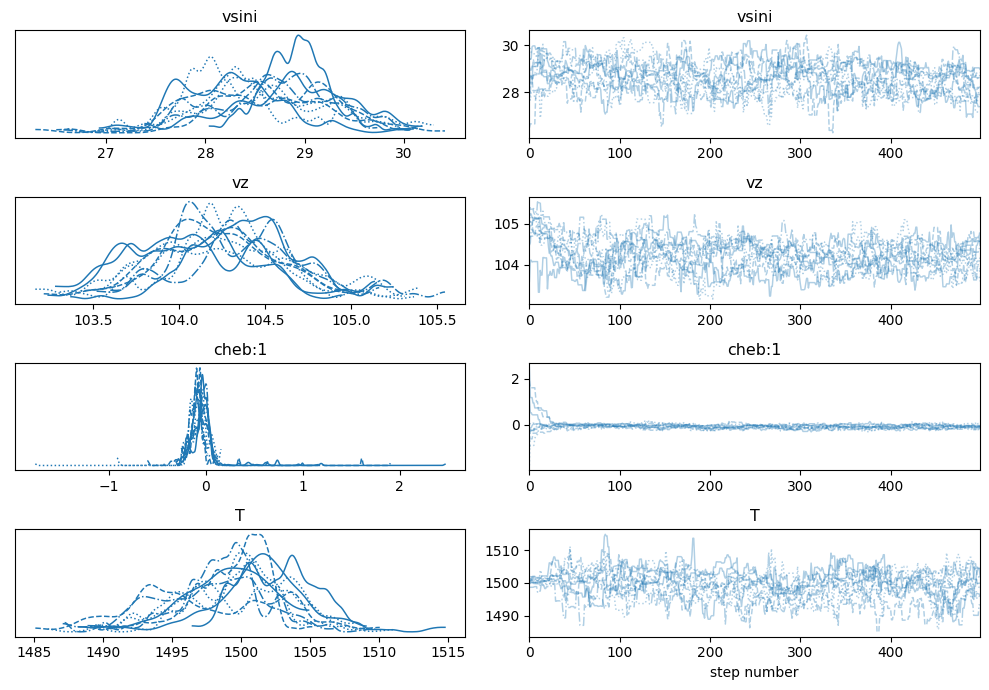

In [17]:
az.plot_trace(full_data, figsize=(10,7));
plt.xlabel("step number")
plt.tight_layout()

After seeing our full traces, let's discard and thin some of the burn-in

In [18]:
tau = reader.get_autocorr_time(tol=0)
burnin = int(tau.max())
thin = int(0.3 * np.min(tau))
burn_samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, thin=thin)

dd = dict(zip(model.labels, burn_samples.T))
burn_data = az.from_dict(dd)

In [19]:
tau

array([29.59017099, 34.0332657 , 25.38357456, 28.31873676])

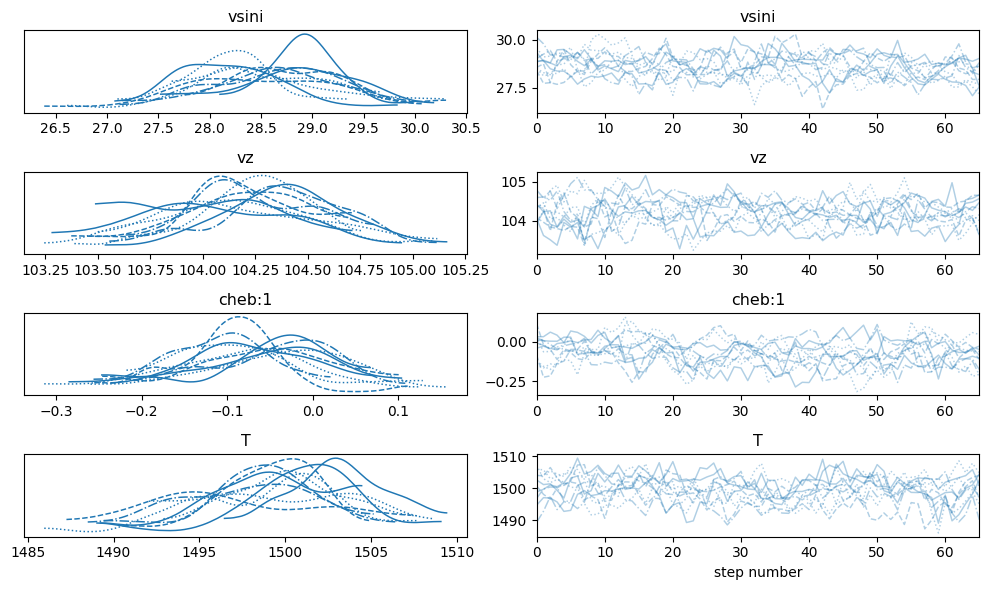

In [20]:
az.plot_trace(burn_data, figsize=(10,6));
plt.xlabel("step number")
plt.tight_layout()

In [21]:
az.summary(burn_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
vsini,28.587,0.623,27.520,29.673,0.094,0.067,44.0,227.0,1.16
vz,104.202,0.346,103.541,104.800,0.047,0.034,53.0,125.0,1.14
cheb:1,-0.072,0.080,-0.224,0.076,0.009,0.007,71.0,370.0,1.11
T,1499.420,4.109,1492.082,1507.377,0.573,0.407,52.0,302.0,1.14


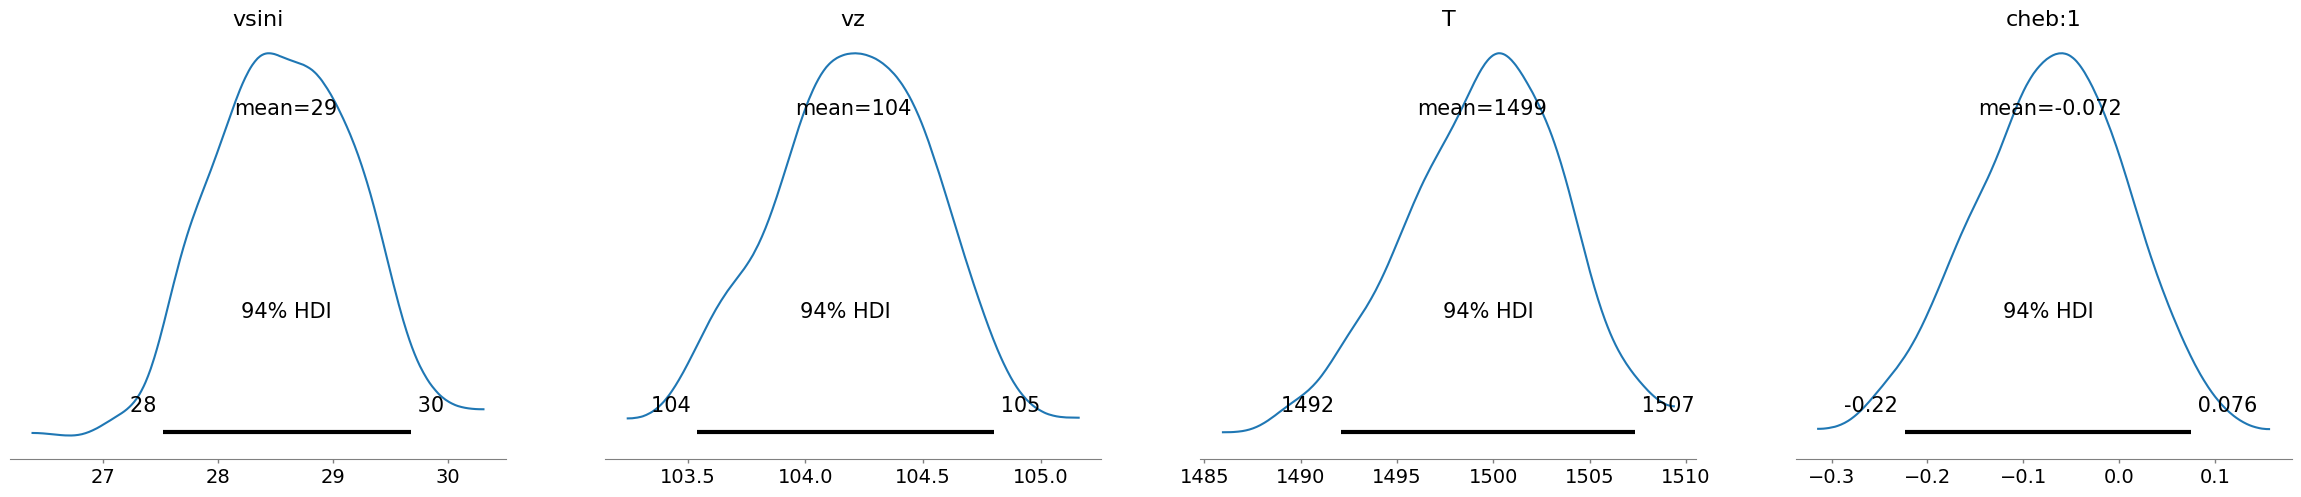

In [22]:
az.plot_posterior(burn_data, ["vsini", "vz", "T", "cheb:1"]);

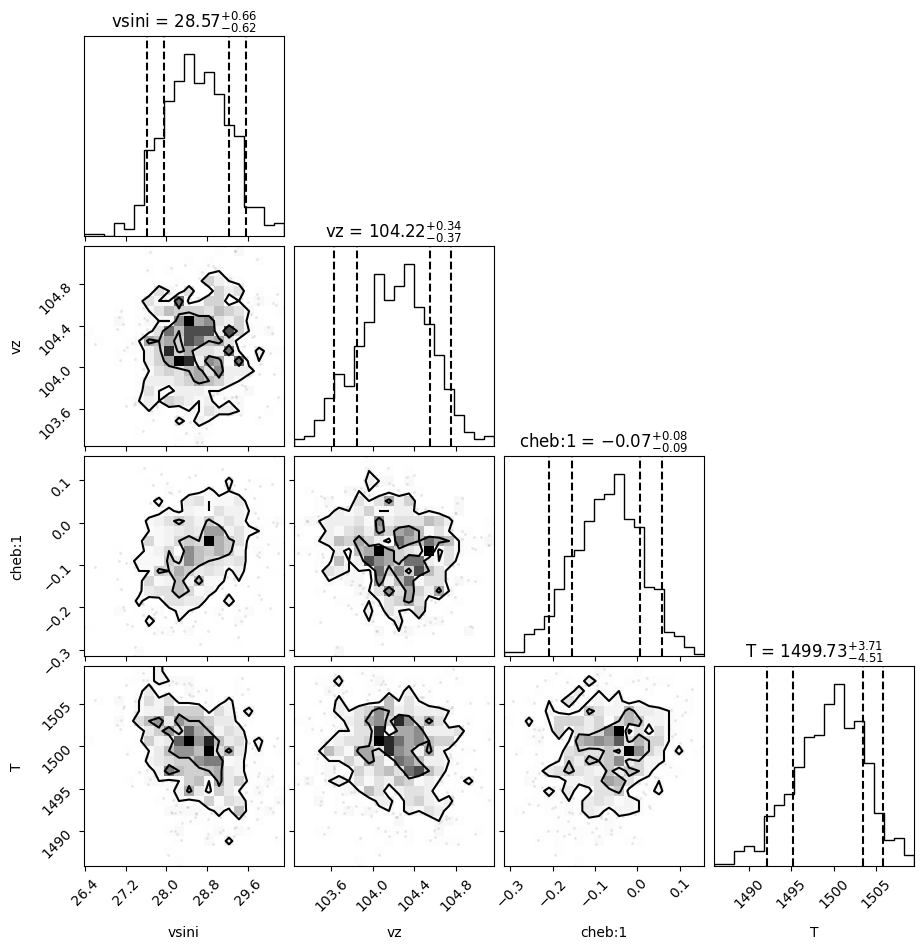

In [23]:
# See https://corner.readthedocs.io/en/latest/pages/sigmas.html#a-note-about-sigmas
#all_samples = reader.get_chain()
sigmas = ((1 - np.exp(-0.5)), (1 - np.exp(-2)))
corner.corner(
    burn_samples.reshape((-1, 4)),
    labels=model.labels,
    quantiles=(0.05, 0.16, 0.84, 0.95),
    levels=sigmas,
    show_titles=True
);

After looking at our posteriors, let's look at our fit

In [24]:
best_fit = dict(az.summary(burn_data)["mean"])
model.set_param_dict(best_fit)
model

SpectrumModel
-------------
Data: Spectrum
Emulator: BTSettl_K_emu
Log Likelihood: -1334.1954245211195

Parameters
  vsini: 28.587
  vz: 104.202
  cheb: [-0.072]
  T: 1499.42
  log_scale: 4.002876788313556 (fit)

Frozen Parameters
  logg: 5.0
  global_cov:log_amp: 1.6251660075783352
  global_cov:log_ls: 0.7454068170363058

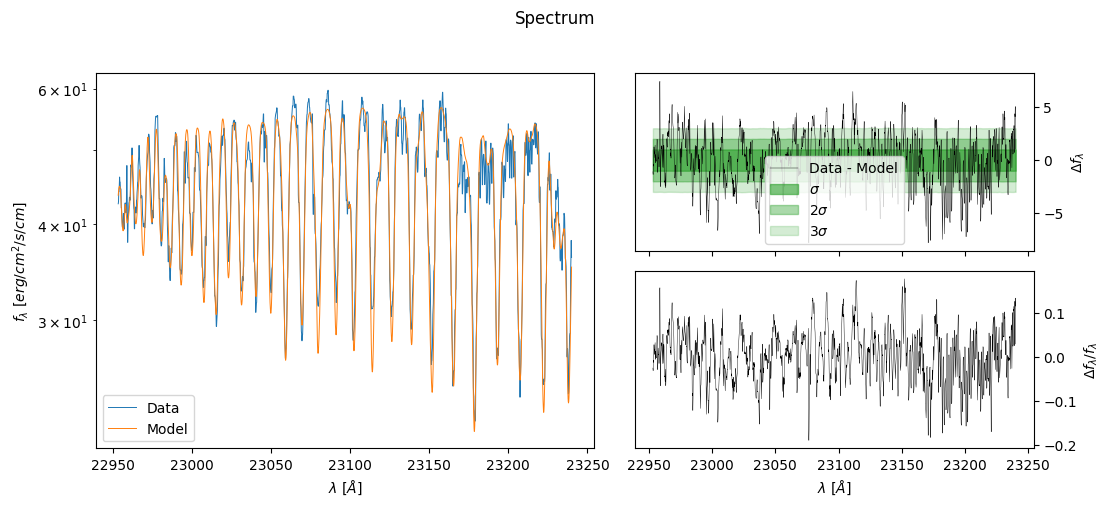

In [49]:
model.plot();

and finally, we can save our best fit.

In [50]:
model.save("example_sampled_1.toml")

Now, on to the next star!